### Import Modules

In [22]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib nbagg

## Lane-Changing Models

In [190]:
def prob_enter(headway, vel, dt, t_cur, t_lc):
    """Probability of a car entering any of the gaps inbetween vehicles

    :returns: boolean array, True if a car enters a gap
                             False if a car does not enter the gap
    """
    
    if (t_cur%t_lc)<dt:
        return(np.logical_and(headway>50, np.random.rand(len(headway))<0.01*dt))
    else:
        return [False]*len(headway)

In [191]:
def prob_exit(headway, vel, dt, t_cur, t_lc):
    """Probability of cars in the lane exitting

    :returns: boolean array, True if a car exits the lane
                             False if a car does not exit the lane
    """
    if (t_cur%t_lc)<dt:
        return(np.logical_and(headway<50, np.random.rand(len(headway))<0.01*dt))
    else:
        return [False]*len(headway)

## Car-Following Model

In [192]:
def car_following(y, t, params):
    """Defines car-following behavior of driver-vehicle units.
       Behvaior here is specified by the Intelligent Driver Model (IDM).

    :y: state of the system
        - first half of the array represents the position of the cars, ordered in decreasing position
        - second half of the array represents the velocity of the cars, ordered as they are in the position half
    :t: time interval
    :params : parameters of the IDM car-following model
              - params['v0']    : desirable velocity [m/s]
              - params['T']     : safe time headway [s]
              - params['a']     : maximum acceleration [m/s2]
              - params['b']     : comfortable decceleration [m/s2]
              - params['delta'] : acceleration exponent [unitless]
              - params['lc']    : average vehicle length [m]
              - params['s0']    : linear jam distance [m]
              - params['s1']    : nonlinear jam distance [m]
              - params['lr']    : length of the circular road [m]
    
    :returns: dydt - derivative of the states (y)
    """
        
    dydt = np.zeros(len(y))
    n = int(len(y)/2)
    
    for i in range(n):
        if i==0:
            ss = 1/(y[n-1] - y[0] - params['lc'] + params['lr'])**2  # inverse square of bumper-to-bumper gap
            vl = y[2*n-1]  # velocity of lead vehicle
        else:
            ss = 1/(y[i-1] - y[i] - params['lc'])**2
            vl = y[n+i-1]

        v = y[n+i]  # velocity of current vehicle

        dydt[i] = v
        dydt[n+i] = params['a'] * (1 - (v/params['v0'])**params['delta'] 
                                   - ss*(params['s0']
                                         + params['s1']*np.sqrt(v/params['v0'])
                                         + params['T']*v 
                                         + 1/(2*np.sqrt(params['a']*params['b']))*v*(vl-v))**2)

    return(dydt)

## Ring Road

In [209]:
class ring_road():
    """
    Simulation of vehicles in a circular lane following the IDM model.
    Vehicles are allowed to enter and exit the lane according to the probability "prob_enter" and "prob_exit"
    Certain vehicle units of your choosing can be held constant in the model for analysis purposes
    """
    
    def __init__(self, params, n_cars, x_init, v_init, ind_cars_const):
        """Instantiates the class with the car-following model parameters
           Initializes road with a set of vehicles with inital positions and velocities
           Specifies vehicles that should not be allowed to exit the road (may be equal to zero)
        
        :params         : parameters of the car-following model, MUST CONTAIN lr and lc
                           - params['lc'] : average vehicle length [m]
                           - params['lr'] : length of the circular road [m]
        :n_cars         : initial number of cars on the road [unitless]
        :x_init         : inital position of each car in the set [m]
        :v_init         : initial velocity of each car in the set [m/s]
        :ind_cars_const : index of cars in the set that should be held constant (length equal to n_cars_const)
        """
        # car-following parameters
        self.params = params
        
        # parameters that are crucial for simulation
        self.lc = params['lc']
        self.lr = params['lr']
        
        # initial conditions of vehicles
        self.n_cars = n_cars
        self.x_init = x_init
        self.v_init = v_init
        
        # cars that cannot exit the road
        self.ind_cars_const = ind_cars_const
    
    
    def simulate(self, dt, t_final, t_lc=0):
        if t_lc == 0:
            t_lc = dt
        n_cars_const = len(self.ind_cars_const)
        
        # initialize empty dataframe to collect lane-change data
        lane_change_df = pd.DataFrame(columns=('time', 'velocity', 'lead_velocity',
                                               'distance_headway', 'type'))
        
        # store constant cars in the first n columns
        ind_variable_cars = np.arange(self.n_cars)
        ind_variable_cars = ind_variable_cars[np.invert(np.in1d(ind_variable_cars,self.ind_cars_const))]
        ind = np.append(self.ind_cars_const, ind_variable_cars).astype(int)
        
        # reorganize inital conditions given new index arrangement
        y0 = np.append(self.x_init[ind], self.v_init[ind])
        
        # time range from 0 to t_final
        t = np.arange(0, t_final+dt, dt)
        
        # initialize variables of interest
        headway = np.zeros((len(t), len(y0)))
        sol = np.zeros((len(t), len(y0)))
        sol[0,:] = y0
        n_cars_tot = self.n_cars  # total number of cars to be in the lane
        n_cars_cur = np.append(self.n_cars, np.zeros(len(t)-1))  # current number of cars in the lane
        ind_cars = np.arange(self.n_cars)
        ind_cars = ind_cars[np.argsort(y0)[:int(len(y0)/2):-1]]  # indeces of the cars currently in the lane
                                                                 # organized in decreasing order of position
        
        for i in range(1,len(t)):
            ########## calculate next position and velocity of current cars in lane ##########
            
            sol_i = odeint(car_following, sol[i-1, np.append(ind_cars, ind_cars+n_cars_tot)], [0,dt], args=(self.params,))
            
            # store new position and velocity data
            sol[i,np.append(ind_cars, ind_cars+n_cars_tot)] = sol_i[-1,:]
            
            # headway of each car currently in the lane
            headway_cur = np.append(sol[i,ind_cars[-1]] - sol[i,ind_cars[0]] + self.lr,
                                    sol[i,ind_cars[:-1]] - sol[i,ind_cars[1:]])
            
            # store new headway data
            headway[i,ind_cars] = headway_cur
            
            
            ######## check for situations of lane changes given velocity and headway #########            
            
            # velocity of each car currently in the lane
            vel_cur = sol[i, ind_cars+n_cars_tot]
            
            enter = prob_enter(headway_cur, vel_cur, dt, t[i], t_lc)  # determine which gaps accept new cars
            exit = prob_exit(headway_cur, vel_cur, dt, t[i], t_lc)    # determine which cars exit the lane
            # ensure that cars that are constant do not exit the lane
            exit = np.logical_and(exit, np.logical_not(np.in1d(ind_cars,np.arange(n_cars_const))))
            
            
            ################### collect exit data in lane-change dataframe ###################
            
            if sum(exit)>0:
                exit_time = t[i]*np.ones(sum(exit))
                exit_vel = vel_cur[exit]
                exit_headway  = headway_cur[exit]
                exit_type = ["Exit"]*sum(exit)
                if exit[0]:
                    exit_lead_vel = np.append(vel_cur[-1:], vel_cur[np.where(exit)[0][1:]-1])
                else:
                    exit_lead_vel = vel_cur[np.where(exit)[0]-1]

                df_exit = pd.DataFrame({'time':exit_time, 'velocity':exit_vel, 'lead_velocity':exit_lead_vel,
                                        'distance_headway':exit_headway, 'type':exit_type})
                lane_change_df = lane_change_df.append(df_exit, ignore_index=True)
            
            
            ############## update variables given cars that entered and/or exit ##############
            
            if sum(enter)>0:
                ind = np.where(enter)[0]
                
                # calculate the position of the new vehicle (halfway point of the gap)
                if enter[0]:
                    x_new = np.append(1/2 * (sol[i, ind_cars[-1]] - sol[i, ind_cars[0]] + self.lr) + 
                                      sol[i, ind_cars[0]], 1/2 * (sol[i, ind_cars[ind[1:]]] +
                                                                  sol[i, ind_cars[ind[1:]-1]]))
                else:
                    x_new = 1/2 * (sol[i, ind_cars[ind]] + sol[i, ind_cars[ind-1]])
                
                # calculate the velocity of the new vehicle ()
                v_new = sol[i, ind_cars[ind]+n_cars_tot]
                
                # calculate the headway of the new vehicle and the vehicle behind it
                h_new = 0.5*headway[i, ind_cars[ind]]
                h_lag_new = h_new - headway[i, ind_cars[ind]]
                
                # add columns to sol to compensate for the presence of new vehicles
                sol = np.insert(sol, [n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                sol = np.insert(sol, [sum(enter)+n_cars_tot+n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                
                # add initial data of new vehicles into sol
                sol[i, np.arange(sum(enter))+n_cars_const] = x_new
                sol[i, np.arange(sum(enter))+n_cars_tot+sum(enter)+n_cars_const] = v_new
                
                # add columns to headway to compensate for the presence of new vehicles
                headway = np.insert(headway, [n_cars_const], np.zeros((headway.shape[0], sum(enter))), axis=1)

                # update data in headway matrix to account for changes
                headway[i, np.arange(sum(enter))+n_cars_const] = h_new
                headway[i, ind_cars[ind]] = h_lag_new
                
                # update lane-change dataframe with cars that entered
                enter_time = t[i]*np.ones(sum(enter))
                enter_type = ["Enter"]*sum(enter)
                df_enter = pd.DataFrame({'time':enter_time, 'velocity':v_new, 'lead_velocity':v_new,
                                         'distance_headway':h_new, 'type':enter_type})
                lane_change_df = lane_change_df.append(df_enter, ignore_index=True)
            
            # update indeces (whether change occured or not), and add cars (if change occured)
            exit = np.logical_or(exit, np.in1d(ind_cars,np.arange(n_cars_const)))
            ind_cars = np.append(np.append(np.arange(n_cars_const), np.arange(sum(enter))+n_cars_const),
                                 ind_cars[np.invert(exit)]+sum(enter))
            # order the indeces by position
            ind_cars = ind_cars[np.argsort(sol[i, ind_cars])[::-1]]
            
            n_cars_tot += sum(enter)
            n_cars_cur[i] = n_cars_cur[i-1] + sum(enter) - sum(exit) + n_cars_const
            
            
        pos_rad = np.divide(sol[:,:int(sol.shape[1]/2)], self.lr) * 2*np.pi  # position in terms of radians
        pos_absolute = sol[:,:int(sol.shape[1]/2)]  # absolute position of every car, in meters
        vel = sol[:,int(sol.shape[1]/2):]  # velocity of every cars at every point in time, 0 if car is not avaialable
        
        return(pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur)

# Main

## Initialization

In [210]:
# define parameters of interest for the car following model
params = {'v0':10/3, 'T':1.6, 'a':0.73, 'b':5/3, 'delta':4, 'lc':4, 's0':2, 's1':3, 'lr':1000}

# specify initial conditions
n_cars = 10  # number of cars
x_init = t = np.arange(0, params['lr'], params['lr']/n_cars)  # initial position of cars
v_init = np.zeros(n_cars)  # initial velocity of cars

# indeces of cars that do not change lanes
ind_cars_const = np.array([0,1,2,3,4,5,7,8,9])

# initialize model
model = ring_road(params, n_cars, x_init, v_init, ind_cars_const)

# Simulation

In [211]:
dt = 0.25         # update time [s]
t_final = 1000  # simulation time [s]

## begin simulation
t1 = time.time()
pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur = model.simulate(dt, t_final)
t2 = time.time()

print("Simulation Time:", t2-t1)

Simulation Time: 5.873728036880493


## Visualization

### Video

<IPython.core.display.Javascript object>


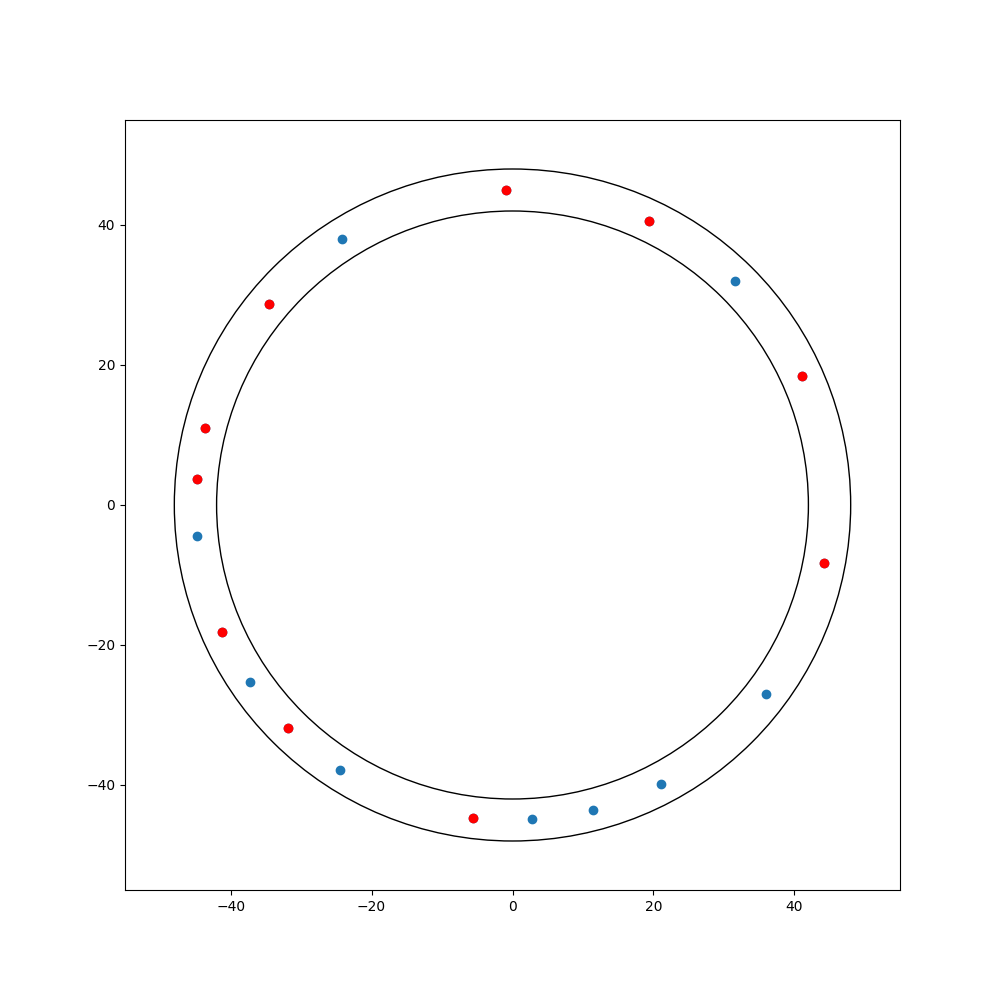

In [183]:
import time
n_cars_const = 10

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# initial x and y data
x = 45 * np.cos(pos_rad)
y = 45 * np.sin(pos_rad)

li1, = ax.plot(x[0,4:], y[0,4:], 'o')
li2, = ax.plot(x[0,:4], y[0,:4], 'o', c='r')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(1,x.shape[0],10):
    # set the new data
    li1.set_xdata(x[i,pos_rad[i,:]!=0])
    li1.set_ydata(y[i,pos_rad[i,:]!=0])
    li2.set_xdata(x[i,pos_rad[i,:n_cars_const]!=0])
    li2.set_ydata(y[i,pos_rad[i,:n_cars_const]!=0])
    
    fig.canvas.draw()
    #time.sleep(0.05)

### Position Profile

<IPython.core.display.Javascript object>


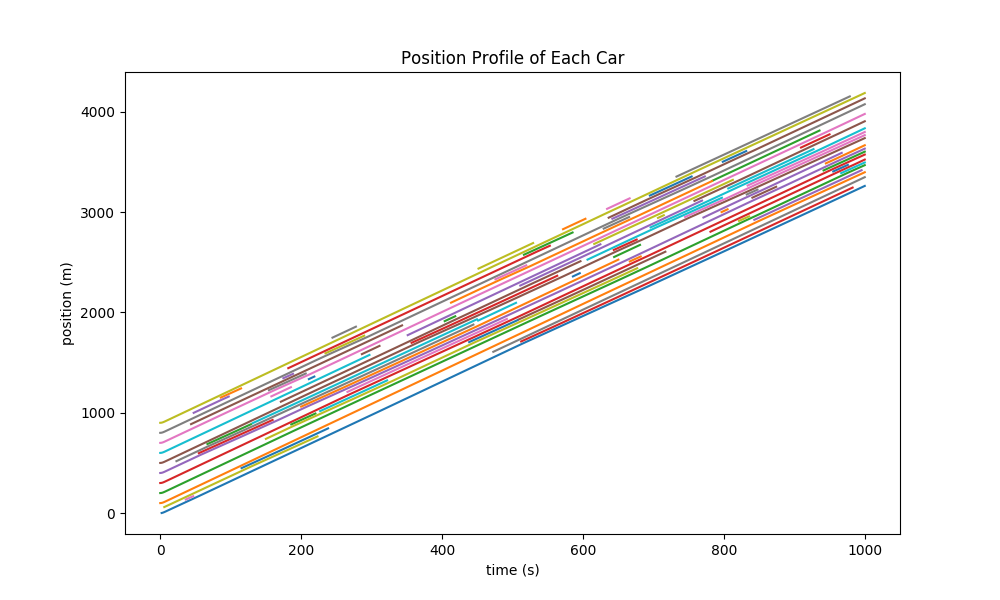

In [187]:
t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(10,6))

for i in range(int(pos_absolute.shape[1])):
    plt.plot(t[pos_absolute[:,i]>1], pos_absolute[pos_absolute[:,i]>1][:,i])

plt.title("Position Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

### Headway Profile

<IPython.core.display.Javascript object>


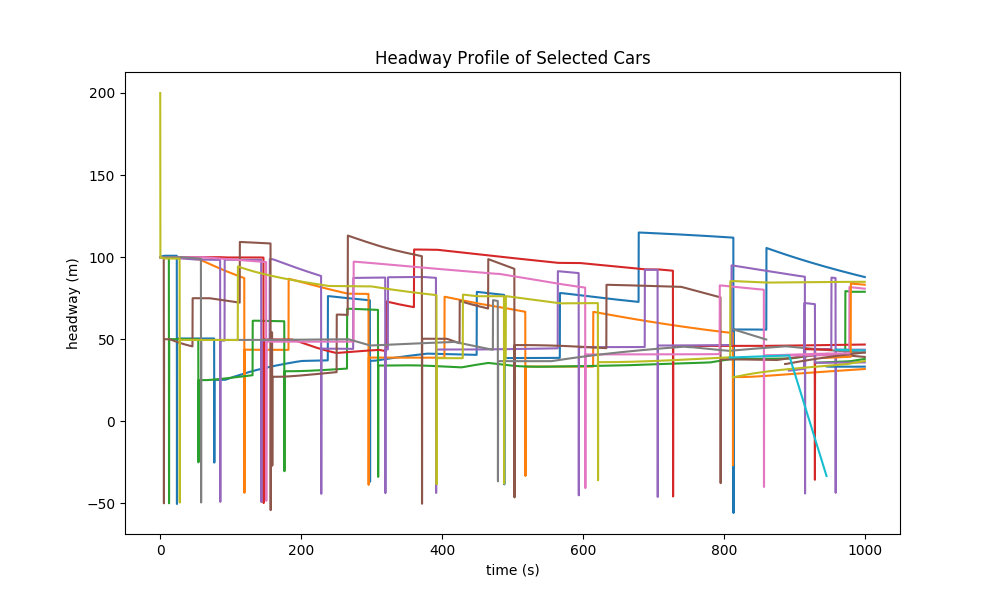

In [214]:
t = np.arange(0, t_final+dt, dt)

# calculate headways of chosen vehicles
n_cars_const = 20

plt.figure(figsize=(10,6))

for i in range(n_cars_const):
    plt.plot(t[headway[:,i]!=0], headway[headway[:,i]!=0][:,i])

plt.title("Headway Profile of Selected Cars")
plt.xlabel('time (s)')
plt.ylabel('headway (m)')
plt.show()

### Velocity Profile

<IPython.core.display.Javascript object>


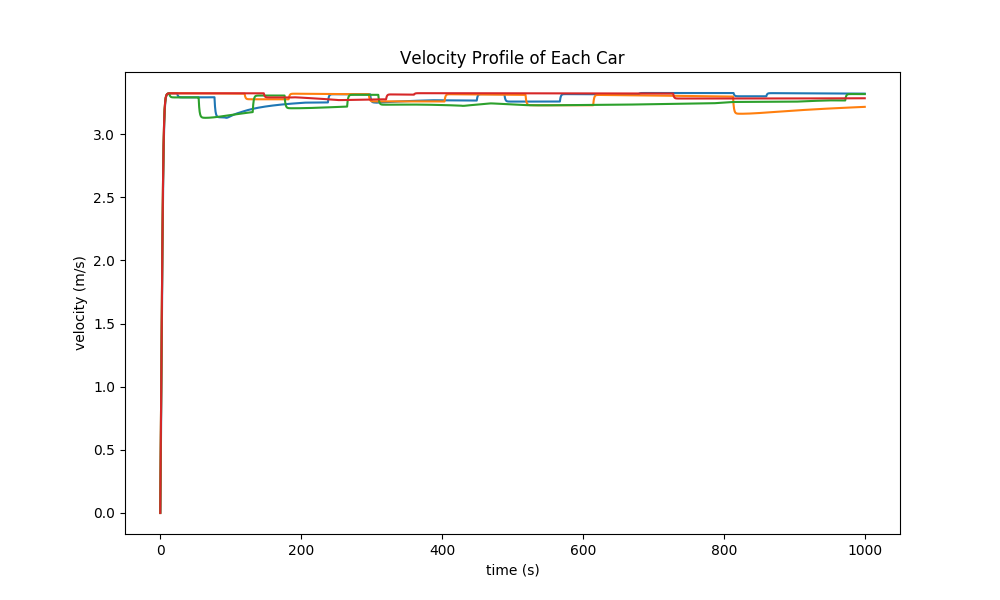

In [215]:
t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(10,6))

for i in range(4):
    plt.plot(t, vel[:,i])

plt.title("Velocity Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()

### Number of Cars vs. Time

<IPython.core.display.Javascript object>


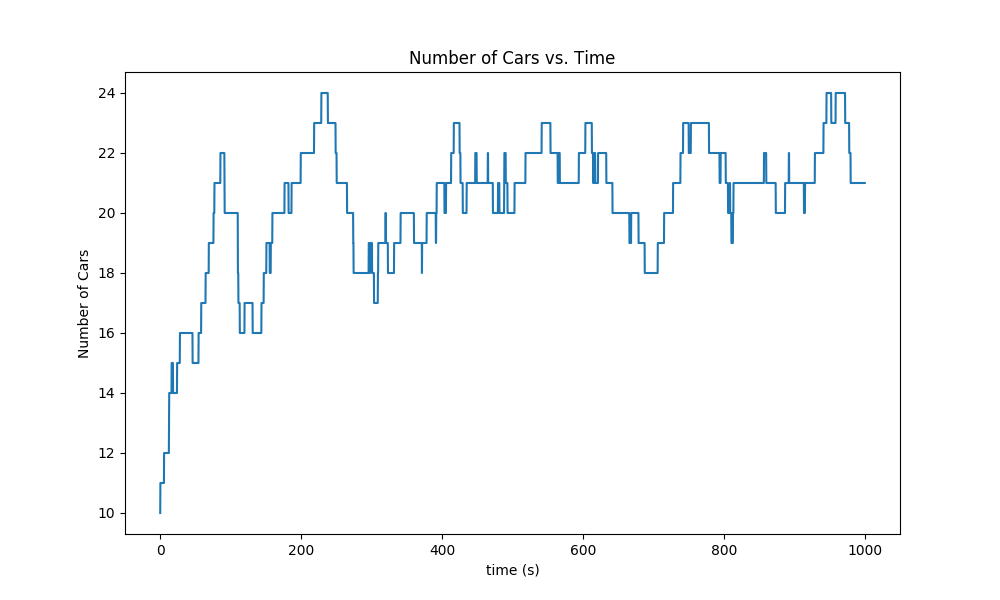

In [218]:
EVL = params['s0']+params['lc']   # effective vehicle length
max_occupancy = params['lr']/EVL  # maximum number of cars on the road

t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(10,6))

plt.plot(t,n_cars_cur)
# max occupancy is onver 160, I recommend not putting
#plt.plot(t,max_occupancy*np.ones(len(t)))

plt.title("Number of Cars vs. Time")
plt.xlabel('time (s)')
plt.ylabel('Number of Cars')
plt.show()

In [212]:
lane_change_df[lane_change_df['type']=='Exit']

,distance_headway,lead_velocity,time,type,velocity
4,49.999834,3.296780,18.25,Exit,3.296961
7,29.311403,3.316059,46.00,Exit,3.186199
15,26.113584,3.173534,91.25,Exit,3.148111
16,49.262435,3.315334,91.50,Exit,3.289624
17,44.884146,3.166927,110.25,Exit,3.282119
18,27.195892,3.215039,110.25,Exit,3.163210
19,30.987205,3.321519,111.00,Exit,3.204781
20,36.967437,3.298830,113.00,Exit,3.250184
22,33.116248,3.296608,131.25,Exit,3.224941
26,49.538029,3.325215,155.50,Exit,3.289804
